# Residential Heat Pump Case Study 3: Hybrid Heating in a Toronto Century Home
Created: 12/2021  
Erik Janssen, Analyst 
Sustainable Technologies Evaluation Program (STEP)  
Toronto and Region Conservation Authority (TRCA)  

## 1 Introduction
This Jupyter Notebook was used to analyze the changes in utility consumption pre- and post-retrofit for the hybrid heating  system analyzed in the accompanying case study. The basic process of the analysis is:

1) Import utility data pre- and post-retrofit.  

2) Estimate current utility rates.

3) Create a linear regression model of the pre-retrofit data as a function of heating degree days (HDDs). This is a baseline against which post-retrofit utility consumption is compared.  

4) Adjust the baseline as required to ensure a fair comparison with actual post-retrofit data.  

5) Estimate the fraction of utility savings from hybrid heating specifically if more than one measure was implemented.  

6) Ensure that the utility impacts attributed to the hybrid heating system is reasonable by calculating the average COP from the gas savings and electricity increase. Compare the calculated average COP against a temperature-weighted COP calculated from manufacturer data (i.e. an expected COP). The COP calculated from the utility data should be lower than that expected based on the manufacturer data. Note COP was not explicitly monitoried, this is just to ensure that it is reasonable to attribute a certain gas savings to the ASHP based on how much electricity it consumed.

7) Calculate other parameters like cost and carbon savings, and perform any other calculations as required.

8) Consider utility implications for carbon pricing scehdule looking out to 2030.



## 2 Libraries

In [5]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import datetime

In [6]:
# Set some basic parameters for plotting and visualizing data
font = {'size'   : 16}
plt.rc('font', **font)
step_blue = "#00a3af"
step_gold = "#f8a81d"
pd.set_option('display.max_columns', None)

## 3 Import Baseline and Post-Retrofit Utility Data

Import the utilty data contained in ".csv" format. The homeowner obtained the pre-retrofit data from the Enbridge online portal and the electricity data from the Toronto Hydro online portals. Post-retrofit gas data was obtained by inspection of actual meter readings from the gas bills that were shared by the homeowner. A different approach was used for post-retrofit gas consumption data because the data directly downloadable from the Enbridge portal is not complete when there are deep gas savings. The Enbridge bimonthly estimates of gas consumption are off to the extent that credits and reversals are required and these do not show up completely in the downloadable data from the Enbridge portal. Note the retrofit happened in October 2020.

In [7]:
# Import post-retrofit
gas_post = pd.read_csv("gas_data_ew_meter_reads.csv",parse_dates=['From','To'])
gas_post

,From,To,Start,End,m3
0,2020-09-22,2020-11-19,68637,68696,59
1,2020-11-20,2021-01-20,68696,68835,139
2,2021-01-21,2021-03-19,68835,69201,366
3,2021-03-20,2021-05-19,69201,69230,29
4,2021-05-20,2021-07-19,69230,69295,65


In [8]:
# Take 6-months of data - install didn't happen until October
gas_post = gas_post.loc[(gas_post.index > 0)&(gas_post.index < 4)] 
gas_post

,From,To,Start,End,m3
1,2020-11-20,2021-01-20,68696,68835,139
2,2021-01-21,2021-03-19,68835,69201,366
3,2021-03-20,2021-05-19,69201,69230,29


In [9]:
# Import baseline gas data
gas_pre_all = pd.read_csv("gas_data_ew_baseline.csv",parse_dates=['From','To'])
gas_pre_all

,From,To,m3,Gas Charge,Gas Charge HST,Invoice Amount
0,2020-08-22,2020-09-21,5,22.92,2.98,25.90
1,2020-07-21,2020-08-21,25,28.71,3.73,32.44
2,2020-06-23,2020-07-20,27,29.28,3.81,33.09
3,2020-05-22,2020-06-22,25,28.71,3.73,32.44
4,2020-04-23,2020-05-21,17,26.40,3.44,29.84
5,2020-03-20,2020-04-22,225,84.74,11.02,84.43
6,2020-02-22,2020-03-19,181,72.71,9.45,82.16
7,2020-01-21,2020-02-21,338,116.13,15.10,8.66
8,2019-12-21,2020-01-20,310,108.47,14.10,122.57
9,2019-11-20,2019-12-20,291,103.37,13.44,116.63


In [10]:
# Make a quick estimate of monthly gas consumption for DHW looking as summer months
# Assumed August 22nd 2020 to September 21st 2020 is an outlier - 5 m3 is strangely low
summer_gas = gas_pre_all.loc[(gas_pre_all.index == 1)|
            (gas_pre_all.index == 2)|
            (gas_pre_all.index == 3)
           ]
monthly_DHW_gas = summer_gas.m3.mean()
monthly_DHW_gas

25.666666666666668

In [11]:
# Now just take the pre-retrofit gas data that approximately matches the timeframe of the post-retrofit data
gas_pre = gas_pre_all.loc[(gas_pre_all.index < 10) & (gas_pre_all.index > 3)]
gas_pre

,From,To,m3,Gas Charge,Gas Charge HST,Invoice Amount
4,2020-04-23,2020-05-21,17,26.40,3.44,29.84
5,2020-03-20,2020-04-22,225,84.74,11.02,84.43
6,2020-02-22,2020-03-19,181,72.71,9.45,82.16
7,2020-01-21,2020-02-21,338,116.13,15.10,8.66
8,2019-12-21,2020-01-20,310,108.47,14.10,122.57
9,2019-11-20,2019-12-20,291,103.37,13.44,116.63


In [12]:
# Quick check on totals pre- and post-
gas_pre.m3.sum()

1362

In [13]:
# Post-retrofit gas summary
gas_post.m3.sum()

534

In [14]:
# Percentage reduction - not yet normalized for weather or other corrections
(1-gas_post.m3.sum()/gas_pre.m3.sum())*100

60.79295154185023

In [15]:
## Import electricity data 
elec = pd.read_csv("elec_data_ew.csv",parse_dates=['From','To'])
elec

,From,To,kWh
0,2019-01-01,2019-01-31,292.89
1,2019-02-01,2019-02-28,237.02
2,2019-03-01,2019-03-28,268.39
3,2019-04-01,2019-04-28,240.88
4,2019-05-01,2019-05-28,212.51
5,2019-06-01,2019-06-28,241.09
6,2019-07-01,2019-07-28,359.47
7,2019-08-01,2019-08-28,294.91
8,2019-09-01,2019-09-28,206.08
9,2019-10-01,2019-10-28,256.73


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


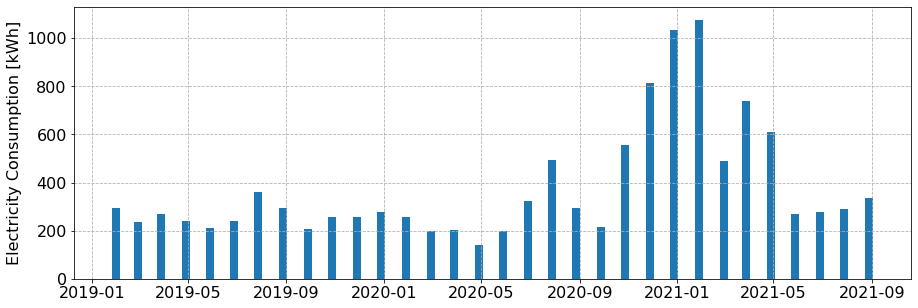

In [16]:
# Visualize electricity
plt.figure(figsize=(15,5))
plt.bar(elec.To,elec.kWh, width = 10)
plt.ylabel('Electricity Consumption [kWh]')
plt.grid(ls='--')

In [17]:
# Define pre-retrofit dataframe
# Note it does not match up perfectly with the gas data - the timeframes are shifted by ~10 days
elec_pre = elec.loc[(elec.index > 10)&(elec.index < 17)]
elec_pre

,From,To,kWh
11,2019-12-01,2019-12-28,276.73
12,2020-01-01,2020-01-28,258.31
13,2020-02-01,2020-02-28,198.55
14,2020-03-01,2020-03-28,204.50
15,2020-04-01,2020-04-28,138.51
16,2020-05-01,2020-05-28,199.98


In [18]:
# Define post-retrofit dataframe
elec_post = elec.loc[(elec.index > 21)&(elec.index < 28)]
elec_pre

,From,To,kWh
11,2019-12-01,2019-12-28,276.73
12,2020-01-01,2020-01-28,258.31
13,2020-02-01,2020-02-28,198.55
14,2020-03-01,2020-03-28,204.50
15,2020-04-01,2020-04-28,138.51
16,2020-05-01,2020-05-28,199.98


In [19]:
# Total pre-retrofit electricity - not adjusted for weather
elec_pre.kWh.sum()

1276.58

In [20]:
# Total post-retrofit electricity - not adjusted for weather
elec_post.kWh.sum()

4760.26

In [21]:
# Increase
elec_post.kWh.sum()/elec_pre.kWh.sum()

3.728916323301321

Without making and adjustments or changes, gas reduced 61% overall and electricity increase by a factor of 3.7.

## 4 Import Heating and Cooling Degree Day Data
It is helpful to have a look at weather normalized utility data. We can normalize using HDDs. Weather data for toronto has been gathered from weatherstats.ca which is essentially just a way of accessing Environment Canada data.

In [22]:
# Import hourly weather data file for Toronto and calculate HDDs
# Assumed building balance point of 14 oC for a better fit to the data
toronto_weather = pd.read_csv("weatherstats_toronto_hourly.csv",parse_dates=True, infer_datetime_format=True)
toronto_weather.date_time_local = [datetime.datetime.strptime(x,'%m/%d/%Y %H:%M') for x in toronto_weather.date_time_local]
toronto_weather = toronto_weather[['date_time_local','temperature']]
toronto_weather['HDDs'] = [(14 - x)*(1/24) if (x < 14) else 0 for x in toronto_weather.temperature] 
toronto_weather.index = toronto_weather.date_time_local
del toronto_weather['date_time_local']
toronto_weather.head()

,temperature,HDDs
date_time_local,,
2021-07-02 08:00:00,18.0,0.0
2021-07-02 07:00:00,16.8,0.0
2021-07-02 06:00:00,16.4,0.0
2021-07-02 05:00:00,16.4,0.0
2021-07-02 04:00:00,16.3,0.0


## 5 Utility Rates and Emission Factors
### 5.1 Natural Gas Rate
The marginal cost of natural gas was estimated using the Ontatio Energy Board (OEB) bill calculator, available at: https://www.oeb.ca/rates-and-your-bill/bill-calculator. Two sample bills were calculated in November 2021 for an Enbridge service area, one for 100 m3 consumption and one for 200 m3. These are shown below. 

![GasBills3.png](GasBills3.png)

The difference in cost between the two bills is 39.3 dollars - for a difference in consumption of 100 m$^{3}$. It follows that the marginal rate for gas was estimated at 0.393 dollars per m3. At the end of 2020 the federal government announced a new cabron pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15 dollars per tonne annually to reach 170 dollars by 2030. It will close to double the current rate by 2030. This has significant implications for hybrid systems and it is considered t the end of this analysis.

In [23]:
# Define gas rate
gas_rate = 0.393 # $/m3

### 5.2 Electricity Rate 
The current marginal electricity rates were also calculated using the OEB bill calculator. Six bills were calculated in total. Each bill assumed that electricity was consumed entirely in only one time-of-use (TOU) bracket. For each TOU bracket a 500 kWh and a 600 kWh was calculated. The difference between the two bills was used to calculated the marginal electricity rate for the TOU. This kind of approach was necessary to properly capture all marginal costs, and is helpful because it is straightforward and electricity pricing structures can be complex with mutiple line items. Bills were calculated in November 2021.

The results for peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is dollars 18.8, leading to marginal peak electricity cost estimate of 0.188 dollars per kWh.
![peak_elec.png](peak_elec.png)

The results for mid-peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is 13.1 dollars, leading to marginal peak electricity cost estimate of 0.131 dollars per kWh.
![mid_elec.png](mid_elec.png)

The results for off-peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is 10.1 dollars, leading to marginal peak electricity cost estimate of  0.101 $\$$/kWh.
![off_elec.png](off_elec.png)

Previous analysis (https://sustainabletechnologies.ca/app/uploads/2021/05/DualFuelAnalysis052021.pdf) estimated that 66% of the heating load occurs in an off-peak TOU and the remainder is roughly split between mid-peak and on-peak. For this home, hour electricity data was provided for part of the 2021 heating season. Can look at when electricity was consumed below.

In [24]:
# Import hourly data
hourly_kWh = pd.read_csv('ew_hourly_kWh.csv',parse_dates=['Start Time'])
hourly_kWh.head()

,Start Time,Wh
0,2021-01-01 05:00:00,1440
1,2021-01-01 06:00:00,1230
2,2021-01-01 07:00:00,1470
3,2021-01-01 08:00:00,1460
4,2021-01-01 09:00:00,1220


In [25]:
# Function that determines which TOU bracket any given hour is in
def TOU(date_time):
    if (date_time.weekday() == 5)|(date_time.weekday() == 6): # Monday is 0; Sunday is 6        
        TOU = 'off'
    elif (date_time.hour < 7)|(date_time.hour > 18):
        TOU = 'off'
    elif (date_time.hour > 10)&(date_time.hour < 17):
        TOU = 'peak'
    else:
        TOU = 'mid'
    return TOU   

In [26]:
# Determine which TOU on an hourly basis
hourly_kWh['TOU'] = [TOU(x) for x in hourly_kWh['Start Time']]
hourly_kWh = hourly_kWh.loc[hourly_kWh['Start Time'] < datetime.datetime.strptime('05/31/2021','%m/%d/%Y')]
hourly_kWh

,Start Time,Wh,TOU
0,2021-01-01 05:00:00,1440,off
1,2021-01-01 06:00:00,1230,off
2,2021-01-01 07:00:00,1470,mid
3,2021-01-01 08:00:00,1460,mid
4,2021-01-01 09:00:00,1220,mid
5,2021-01-01 10:00:00,1380,mid
6,2021-01-01 11:00:00,1280,peak
7,2021-01-01 12:00:00,1300,peak
8,2021-01-01 13:00:00,1160,peak
9,2021-01-01 14:00:00,1180,peak


In [27]:
# Offpeak electricity 
offpeak_total = hourly_kWh.loc[hourly_kWh.TOU == 'off'].Wh.sum()/1000
offpeak_total

1850.96

In [28]:
# Peak electricity
peak_total = hourly_kWh.loc[hourly_kWh.TOU == 'peak'].Wh.sum()/1000
peak_total

676.24

In [29]:
# Mid-peak electricity
midpeak_total = hourly_kWh.loc[hourly_kWh.TOU == 'mid'].Wh.sum()/1000
midpeak_total

651.21

In [30]:
# Total electricity
total = offpeak_total + peak_total + midpeak_total
total

3178.41

In [31]:
# Offpeak fraction
off_frac = offpeak_total/total
off_frac

0.5823540701168195

In [32]:
# Peak fraction
peak_frac = peak_total/total    
peak_frac

0.21276046828445672

In [33]:
# Mid-peak fraction
mid_frac = midpeak_total/total
mid_frac

0.20488546159872392

In [34]:
# Weighted electricity rate for these fractions
elec_rate = 0.101 * off_frac + 0.131 * mid_frac + 0.188 * peak_frac
elec_rate

0.12565672458870947

In [35]:
# Comparison the report that estimate 66% off-peak and 17% mid-peak and 17% peak
# Define elec rates
elec_rate2 = 0.66*0.101 + 0.131*(0.33/2) + 0.188*(0.33/2)
elec_rate2

0.11929500000000003

The actual TOU breakdown of electricity was somewhat close to expectations - and the rates would be very similar regardless of which assumption is used. This analysis will use the rate weighted to actual consumption as a best estimate.

### 5.3 Summary 

In [36]:
print("The gas rate is " + str(gas_rate) + ' dollars per cubic meter.')
print("The electricity rate for the heat pump is " + str(elec_rate)[:5] + ' dollars per kWh.')

The gas rate is 0.393 dollars per cubic meter.
The electricity rate for the heat pump is 0.125 dollars per kWh.


### 5.4 Emission Factors

The emission factors for electricity and natural gas are discussed in the whitepaper linked above. The emission factor for electricity was estimated at 0.030 kg equivalent CO2 per kWh. The emission factor for natural gas combustion was assumed at 1.89 kg equivalent CO2 per cubic metre. Values are from the 2021 Canadian National Inventory Report.

In [37]:
# Define emission factor assumptions
EF_elec = 0.030 # assuming an annual emission factor of 0.030 according to 2021 NIR report
EF_gas = 1.89 # in units kg CO2e per m3

## 6 Define Regression Models of Utility Consumption, Make Adjustments and Calculate Utility Impacts
### 6.1 Gas Baseline Calculation
We can now add HDDs to the utility consumption dataframes.

In [38]:
# Function that determines total HDDs in a given window of time
def HDD_total(start_date,end_date):
    temp_df = toronto_weather.loc[(toronto_weather.index>start_date)&(toronto_weather.index<end_date)]
    total_HDDs = temp_df.HDDs.sum()
    return {'HDDs':total_HDDs}

In [39]:
# Add HDDs to gas post-retrofit dataframe
gas_post['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(gas_post.From,gas_post.To)]
gas_post

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,From,To,Start,End,m3,HDDs
1,2020-11-20,2021-01-20,68696,68835,139,820.900000
2,2021-01-21,2021-03-19,68835,69201,366,990.975000
3,2021-03-20,2021-05-19,69201,69230,29,338.745833


In [40]:
# Add HDDs to gas pre-retrofit dataframe
gas_pre['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(gas_pre.From,gas_pre.To)]
gas_pre_all['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(gas_pre_all.From,gas_pre_all.To)]
gas_pre

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,From,To,m3,Gas Charge,Gas Charge HST,Invoice Amount,HDDs
4,2020-04-23,2020-05-21,17,26.40,3.44,29.84,158.058333
5,2020-03-20,2020-04-22,225,84.74,11.02,84.43,305.491667
6,2020-02-22,2020-03-19,181,72.71,9.45,82.16,325.058333
7,2020-01-21,2020-02-21,338,116.13,15.10,8.66,511.295833
8,2019-12-21,2020-01-20,310,108.47,14.10,122.57,412.900000
9,2019-11-20,2019-12-20,291,103.37,13.44,116.63,424.879167


In [41]:
# HDDs pre-retrofit
gas_pre.HDDs.sum()

2137.683333333333

In [42]:
# HDDs post-retrofit
gas_post.HDDs.sum()

2150.6208333333334

They are with 1% of eachother.

In [43]:
# Calculate regression line for baseline data
x = np.array(gas_pre_all.HDDs).reshape((-1, 1))
y = np.array(gas_pre_all.m3)
base_model_gas = LinearRegression()
base_model_gas.fit(x, y)
base_model_gas_r_sq = base_model_gas.score(x, y)
print('coefficient of determination:', base_model_gas_r_sq)
print('intercept:', base_model_gas.intercept_)
print('slope:', base_model_gas.coef_)

coefficient of determination: 0.9309828930417567
intercept: -2.506424348623881
slope: [0.66675626]


In [44]:
# Function for baseline model
def baseline_gas(HDDs):
    m3 = base_model_gas.coef_[0]*HDDs + base_model_gas.intercept_
    return m3

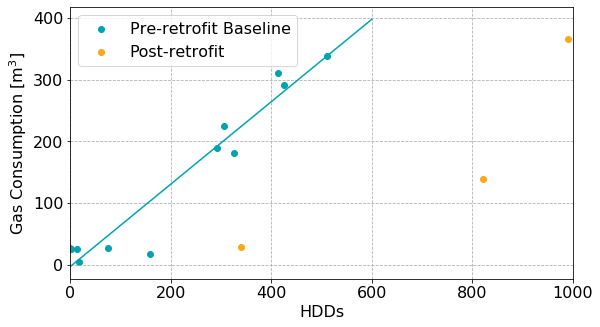

In [45]:
# Visualize pre-retrofit data, baseline model, and post-retrofit data
x = [0,600]
y = [baseline_gas(a) for a in x]
plt.figure(figsize = (9,5))
plt.scatter(gas_pre_all.HDDs,gas_pre_all.m3, color = step_blue, label = 'Pre-retrofit Baseline')
plt.plot(x,y, color = step_blue)
plt.xlim(0,1000)
plt.xlabel('HDDs')
plt.ylabel('Gas Consumption [m$^{3}$]')
plt.grid(ls='--')
plt.scatter(gas_post.HDDs,gas_post.m3, color = step_gold, label = 'Post-retrofit')
plt.legend(loc = 2)

Note that post-retrofit is bimonthly data and pre-retrofit is monthly data. As HDDs increase, relative savings is less because furnace is used more. Regression model sees intercept is near zero. Intercept is gas consumption for DHW. If we were trying to predict gas consumption during the summer months this would not suffice. However, it is ok for the 6 winter months we are looking at.

In [46]:
# Calculate baseline gas consumption - applying baseline model to post-retrofit HDDs
gas_post['baseline'] = [baseline_gas(HDD) for HDD in gas_post.HDDs]
gas_post

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,From,To,Start,End,m3,HDDs,baseline
1,2020-11-20,2021-01-20,68696,68835,139,820.900000,544.833787
2,2021-01-21,2021-03-19,68835,69201,366,990.975000,658.232358
3,2021-03-20,2021-05-19,69201,69230,29,338.745833,223.354480


In [47]:
# Calculate post-retrofit actual gas total
gas_post_act = gas_post.m3.sum()
gas_post_act

534

In [48]:
# Calculate baseline gas consumption using post-retrofit HDDs
gas_post_baseline_mod = gas_post.baseline.sum()
gas_post_baseline_mod

1426.420624731733

Interestingly, the baseline model estimates baseline gas usage at 1,426 m3 while the actual pre-retrofit consumption was 1,362 m3. The estimate is off by 5% but the difference in HDDs is only 1%. Erring on the side of a more conservative estimate of gas savings we'll just use the actual value (since the HDDs are so close anyway).

In [49]:
# Baseline gas consumption uncorrected
gas_post_baseline = gas_pre.m3.sum()
gas_post_baseline

1362

### 6.2 Gas Baseline Correction for HRV

The HRV added a new heat load to the post-retrofit data that was not their in the pre-retrofit data. This can be corrected by making an adjustment to the baseline that increases the gas consumption. Note that the larger corrections will make the calculate gas savings from the hybrid savings larger. Therefore , the correction should err on the conservative side. If it is too large it will create an unrealistically large estimate for the COP - and this is a way of ensuring that the correction is reasonable.

In [50]:
# Import temperature data for post-retrofit period 
start = datetime.datetime.strptime('11/20/2020','%m/%d/%Y')
stop = datetime.datetime.strptime('05/19/2021','%m/%d/%Y')
post_weather_all = toronto_weather.loc[(toronto_weather.index > start)&
                                   (toronto_weather.index < stop)&
                                   (toronto_weather.temperature < 14)]

In [51]:
# Parameter assumptions for HRV corrections
house_volume_ft3 = 1500 * (8) # 1500 ft (across 2 floors assuming 8 ft ceilings) - results in cubic ft
house_volume_m3 =  house_volume_ft3/35.3
ACH_upgrade = 0.5 # HRV is operating on low at all times - ASHRAE recommends minimum 0.35 ACH for good air quality - 0.5 ACH is a best estimate
HRV_eff = 0.75 # Assumed 75% of the heat from the outgoing air is transferred to the incoming air - https://www.lifebreath.com/product/lifebreath-95-max-residential-heat-recovery-ventilator-hrv/
indoor_temp = 21
air_dens = 1.3 # kg/m3 it varies with temp and pressure but this is a high level calculation so assumed average value
cp = 1004 # J/(kgC) heat capacity of air
furnace_eff = 0.90 # Efficiency for previous furnace - assumed slightly degraded efficiency
gas_energy_dens = 0.038 # GJ/m3

# Function to calculate energy from ventilation air for a given hour based on average outdoor temperature
def vent_energy(temp):
    if temp < 14:
        GJ = house_volume_m3 * ACH_upgrade * (1 - HRV_eff) * air_dens * cp * (21 - temp) * (1/1e9) # GJ 
    else:
        GJ = 0
    return GJ

In [52]:
# Calculate additional energy required for ventilation on an hourly basis
post_weather_all['Vent_Energy_GJ'] = [vent_energy(x) for x in post_weather_all.temperature]
post_weather_all.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,temperature,HDDs,Vent_Energy_GJ
date_time_local,,,
2021-05-18 07:00:00,13.8,0.008333,0.000399
2021-05-18 06:00:00,12.7,0.054167,0.000460
2021-05-18 05:00:00,12.8,0.050000,0.000455
2021-05-18 04:00:00,13.7,0.012500,0.000405
2021-05-18 01:00:00,12.8,0.050000,0.000455


In [53]:
# Total extra heating energy due to added ventilation
vent_energy_tot = post_weather_all.Vent_Energy_GJ.sum()
vent_energy_tot

4.476118694617565

In [54]:
# Gas required from previous system for added ventilation
vent_energy_gas_m3 = vent_energy_tot * (1/furnace_eff) * (1/gas_energy_dens)
vent_energy_gas_m3

130.88066358530892

In [55]:
# % correction with respect to baseline data
vent_energy_gas_m3/gas_post_baseline*100

9.609446665588028

The correction for the HRV is relatively small at 10%.

In [56]:
# Corrected gas consumption baseline
gas_post_baseline_corr = gas_post_baseline + vent_energy_gas_m3
gas_post_baseline_corr

1492.8806635853089

The baseline gas energy with the correction is an estimate of the gas consumption that would have occurred during the post-retrofit period if the former furnace was used and the only upgrade was the HRV.

### 6.3 Gas Consumption and Savings Calculations

In [57]:
# Calculate gas reduction
gas_savings = gas_post_baseline_corr - gas_post_act
gas_savings

958.8806635853089

In [58]:
# Calculate gas reduction as perecentage 
gas_savings/gas_post_baseline_corr*100

64.2302286428211

Now I want to break the gas savings up between the tankless water heater upgrade and the hybrid system.

In [59]:
# Estimated baseline gas consumption for water heating
gas_baseline_DHW = 6*monthly_DHW_gas
gas_baseline_DHW

154.0

In [60]:
# Estimated baseline gas consumption for space heating
gas_baseline_SH = gas_post_baseline_corr - gas_baseline_DHW
gas_baseline_SH

1338.8806635853089

In [61]:
# Estimated gas savings from tankless water heater
tankless_eff = 0.98
storage_WH_eff = 0.65 # An estimate - tankless water heaters are notoriously inefficient
gas_savings_DHW = gas_baseline_DHW * (tankless_eff - storage_WH_eff)
gas_savings_DHW

50.81999999999999

In [62]:
# Gas consumption for DHW post-retrofit
gas_post_DHW = gas_baseline_DHW - gas_savings_DHW
gas_post_DHW

103.18

In [63]:
# Gas consumption for SH post-retrofit
gas_post_SH = gas_post_act - gas_post_DHW
gas_post_SH

430.82

In [64]:
# Gas savings for SH
gas_savings_SH = gas_savings - gas_savings_DHW
gas_savings_SH

908.0606635853089

In [65]:
# Gas savings for SH in %
gas_savings_SH/gas_baseline_SH

0.6782237493472102

In [66]:
# Gas savings for DHW in %
gas_savings_DHW/gas_baseline_DHW*100

32.99999999999999

In [67]:
# Remaining gas that could be saved from a cold-climate system
gas_baseline_SH-gas_savings_SH

430.81999999999994

### 6.4 Electricity Baseline Regression Model

coefficient of determination: 0.3017428536781458
intercept: 144.61175297958437
slope: [0.21504245]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


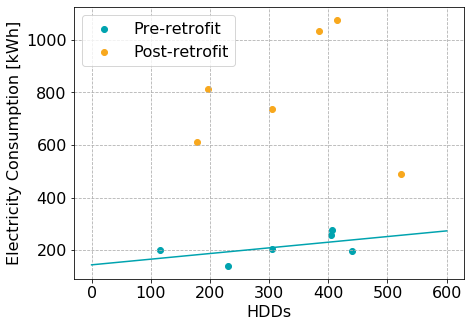

In [68]:
# Add HDDs to electricity dataframe
elec_pre['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(elec_pre.From,elec_pre.To)]
elec_post['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(elec_post.From,elec_post.To)]

# Calculate regression line for baseline data
x = np.array(elec_pre.HDDs).reshape((-1, 1))
y = np.array(elec_pre.kWh)
base_model_elec = LinearRegression()
base_model_elec.fit(x, y)
base_model_elec_r_sq = base_model_elec.score(x, y)
print('coefficient of determination:', base_model_elec_r_sq)
print('intercept:', base_model_elec.intercept_)
print('slope:', base_model_elec.coef_)

# Define baseline elec function
def base_elec_model(HDDs):
    kWh = base_model_elec.coef_[0]*HDDs + base_model_elec.intercept_
    return kWh

# Visualize
plt.figure(figsize = (7,5))
plt.grid(ls='--')
x = [0,600]
y = [base_elec_model(a) for a in x]
plt.scatter(elec_pre.HDDs,elec_pre.kWh, color = step_blue, label = 'Pre-retrofit')
plt.scatter(elec_post.HDDs,elec_post.kWh, color = step_gold, label = 'Post-retrofit')
plt.plot(x,y, color = step_blue)
plt.xlabel('HDDs')
plt.ylabel('Electricity Consumption [kWh]')
plt.legend()

In [69]:
elec_post['Baseline'] = [base_elec_model(HDDs) for HDDs in elec_post.HDDs]
elec_post

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,From,To,kWh,HDDs,Baseline
22,2020-11-01,2020-11-28,813.80,196.179167,186.798601
23,2020-12-01,2020-12-28,1032.93,384.070833,227.203284
24,2021-01-01,2021-01-28,1075.86,414.804167,233.812255
25,2021-02-01,2021-02-28,490.45,522.787500,257.033255
26,2021-03-01,2021-03-28,737.67,304.791667,210.154898
27,2021-04-01,2021-04-28,609.55,178.245833,182.942173


[Text(0, 0, 'Dec'),
 Text(0, 0, 'Jan'),
 Text(0, 0, 'Feb'),
 Text(0, 0, 'Mar'),
 Text(0, 0, 'Apr'),
 Text(0, 0, 'May')]

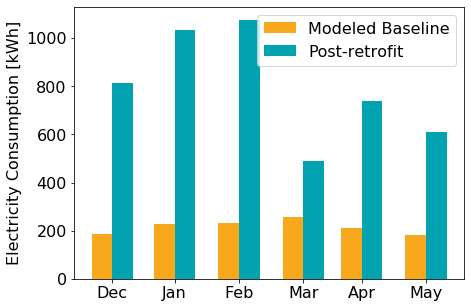

In [70]:
#Visualize
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(elec_post.From,elec_post.Baseline,width=-10,align='edge', label = 'Modeled Baseline', color = step_gold)
ax.bar(elec_post.From,elec_post.kWh,width=10,align='edge',label = 'Post-retrofit', color = step_blue)
ax.set_ylabel('Electricity Consumption [kWh]')
ax.legend(loc=0)
ax.set_xticklabels(['Dec','Jan','Feb','Mar','Apr','May'])

In [71]:
# Total electricity baseline
baseline_elec = elec_post.Baseline.sum()
baseline_elec

1297.94446695692

In [72]:
# Actual post-retrofit elec
elec_post_total = elec_post.kWh.sum()
elec_post_total

4760.26

### 6.5 Electricity Baseline Adjustment for HRV


In [73]:
# Assume HRV was running all the time at low power (59 W)
HRV_elec = 0.059 * (8760/2) # 8760 hours in a year, divide by 2 for 6 months
HRV_elec

258.41999999999996

In [74]:
# As a fraction of the total post-retrofit electricity consumption it's pretty small
HRV_elec/elec_post_total

0.05428695071277618

In [75]:
# Add to Baseline
baseline_elec_corr = baseline_elec + HRV_elec
baseline_elec_corr

1556.3644669569198

### 6.6 Electricity Increase

In [76]:
# Calculate electricity increase (due entirely to hybrid system)
elec_increase = elec_post_total - baseline_elec_corr
elec_increase

3203.8955330430804

### 6.7 Calculation Check

To check if the gas savings is reasonable compared to the electricity incease, it possible to make a calculation to estimate the as-installed COP. This can be compared against a temperature-weighted COP based on manufacturer data. The as-installed number should be lower due to real-world factors like cycling and defrost. Manufacturer data is below.

![hp_specs.png](hp_specs.png)

coefficient of determination: 0.9927390391610988
intercept: 3.1711272727272726
slope: [0.09597818]


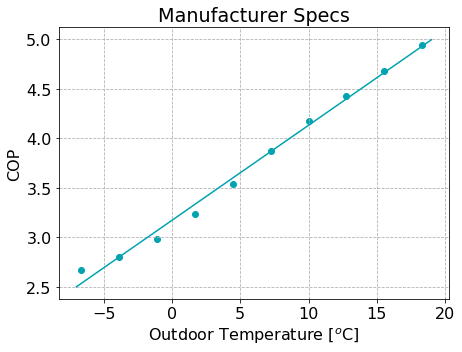

In [77]:
# Manufacturer COP data 
COP_Temps_F = [65, 60, 55, 50, 45, 40, 35, 30, 25, 20]
COP_Temps_C = [(x-32)*(5/9) for x in COP_Temps_F]
COPs = [4.94, 4.68, 4.43, 4.17, 3.87, 3.54, 3.23, 2.98, 2.80, 2.67]

# Visulualize COP data
plt.figure(figsize = (7,5))
plt.scatter(COP_Temps_C, COPs, color = step_blue)
plt.xlabel('Outdoor Temperature [$^{o}$C]')
plt.ylabel('COP')

# Calculate regression model for COP
x = np.array(COP_Temps_C).reshape((-1, 1))
y = np.array(COPs)
COP_model = LinearRegression()
COP_model.fit(x, y)
COP_model_r_sq = COP_model.score(x, y)
print('coefficient of determination:', COP_model_r_sq)
print('intercept:', COP_model.intercept_)
print('slope:', COP_model.coef_)

# Define COP Function
def COP_func(Temp):
    COP = COP_model.coef_[0] * Temp + COP_model.intercept_
    return COP

# Plot model
x = np.arange(-7,20,1)
y = [COP_func(a) for a in x]
plt.plot(x,y, color = step_blue)    
plt.title('Manufacturer Specs')
plt.grid(ls='--')

In [78]:
# Calculate temperature-weighted COP for post-retrofit period
start = datetime.datetime.strptime('11/20/2020','%m/%d/%Y')
stop = datetime.datetime.strptime('05/19/2021','%m/%d/%Y')
post_weather_hp = toronto_weather.loc[(toronto_weather.index > start)&
                                   (toronto_weather.index < stop)&
                                   (toronto_weather.temperature < 14)&
                                   (toronto_weather.temperature > -5)] # only operated above -5oC
post_weather_hp['COP'] = [COP_func(x) for x in post_weather_hp.temperature]
temp_weighted_COP = post_weather_hp.COP.mean()
temp_weighted_COP

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


3.4651695206611635

The as-installed COP must be less than 3.5.

In [79]:
# Calculated an as-installed COP
# Gas savings is from heat that was formerly delivered by a heat pump but is now delivered by heat pump

gas_m3_to_kWh = 10.6 # Assume 10.6 kWh per m3

as_installed_COP =  (gas_savings_SH * furnace_eff * gas_m3_to_kWh) / elec_increase
as_installed_COP


2.7038642930956525

In [80]:
as_installed_COP/temp_weighted_COP

0.780297840256816

This is reasonable. Note that there was no robust monitoring of COP in this case study, and the as-installed is subject to uncertainty based on some of the estimates that have gone into the analysis. The purpose of calculated here is simply to show that gas savings that were attributed to the heat are reasonable. It was estimated that the as-installed COP was 22% lower than the manufacturer values. This is expected due to real-world factors like cycling and defrost. The amount of gas savings attributed to the heat pump, and it's estimated electricity consumption, are therefore reasonable.

### 6.8 Net Cost and Carbon

In [81]:
# Gas cost savings both DHW and hybrid system
gas_cost_savings = gas_savings * gas_rate
gas_cost_savings

376.8401007890264

In [82]:
# Gas cost savings for space heating
gas_cost_savings_SH = gas_savings_SH * gas_rate
gas_cost_savings_SH

356.86784078902645

In [83]:
# Electricity cost increase - entirely due to ASHP
elec_increase_cost = elec_increase * elec_rate
elec_increase_cost

402.59101860659086

In [84]:
# Net cost for SH
net_SH_cost_increase = elec_increase_cost - gas_cost_savings_SH 
net_SH_cost_increase

45.72317781756442

In [85]:
# Net cost overall
net_cost_increase =  elec_increase_cost - gas_cost_savings 
net_cost_increase

25.75091781756447

In [86]:
# Net carbon savings for space heating
net_carb_SH = gas_savings_SH * EF_gas
net_carb_SH

1716.2346541762338

In [87]:
# Create lists for plot
baseline = [gas_post_baseline_corr*gas_rate,baseline_elec_corr*elec_rate]
postretrofit = [gas_post_act*gas_rate,elec_post_total*elec_rate]
reduction = [net_cost_increase]

(0, 800)

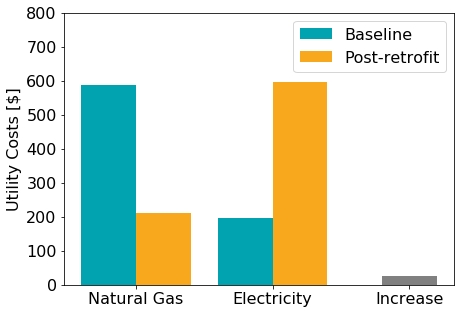

In [88]:
# Plot 
fig, ax = plt.subplots(figsize = (7,5))
ax.bar([1,2], baseline, width = -0.4, align = 'edge', color = step_blue, label = 'Baseline')
ax.bar([1,2], postretrofit, width = 0.4, align = 'edge', color = step_gold, label = 'Post-retrofit')
ax.bar([3],reduction, color = 'grey', width = 0.4)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Natural Gas','Electricity', 'Increase'])
ax.set_ylabel('Utility Costs [$]')
ax.legend()
ax.set_ylim(0,800)

## 7 Annual Utility Costs to 2030

At the end of 2020 the federal government announced a new carbon pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15$\$$ per year to reach $\$$170 by 2030. This has significant implications for dual fuel heat pump systems. This is outlined in the dataframe below. It ignores other fluctuations in the cost of natural gas and simply adds additional charges onto the current rate.

In [89]:
# Import carbon charge data
# You can see this aligns with carbon charge data from enbridge
# https://www.enbridgegas.com/residential/my-account/rates/federal-carbon-charge (below)
nat_gas_rate_df = pd.read_csv("nat_gas_carbon_pricing.csv")
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3)
0,2021,40,0.078300
1,2022,50,0.097875
2,2023,65,0.127238
3,2024,80,0.156600
4,2025,95,0.185963
5,2026,110,0.215325
6,2027,125,0.244688
7,2028,140,0.274050
8,2029,155,0.303412
9,2030,170,0.332775


![Enbridge_CC2.png](Enbridge_CC2.png)

In [91]:
# Add cost escalation due to carbon charge
gas_rate_no_carbon_charge = gas_rate - 0.078
nat_gas_rate_df['Gas_Rate'] = [gas_rate_no_carbon_charge + x for x in nat_gas_rate_df['Carbon Charge Natural Gas ($/m3)']]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate
0,2021,40,0.078300,0.393300
1,2022,50,0.097875,0.412875
2,2023,65,0.127238,0.442238
3,2024,80,0.156600,0.471600
4,2025,95,0.185963,0.500962
5,2026,110,0.215325,0.530325
6,2027,125,0.244688,0.559688
7,2028,140,0.274050,0.589050
8,2029,155,0.303412,0.618413
9,2030,170,0.332775,0.647775


In [92]:
# Add electricity cost escalation - 
# Assume 2% per year there has been no recent long-term energy plan to for a better estimate
# Just add it to natural gas data frame
nat_gas_rate_df['Elec_Rate'] = [elec_rate*(1.02)**x for x in nat_gas_rate_df.index]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Elec_Rate
0,2021,40,0.078300,0.393300,0.125657
1,2022,50,0.097875,0.412875,0.128170
2,2023,65,0.127238,0.442238,0.130733
3,2024,80,0.156600,0.471600,0.133348
4,2025,95,0.185963,0.500962,0.136015
5,2026,110,0.215325,0.530325,0.138735
6,2027,125,0.244688,0.559688,0.141510
7,2028,140,0.274050,0.589050,0.144340
8,2029,155,0.303412,0.618413,0.147227
9,2030,170,0.332775,0.647775,0.150171


In [93]:
# Add utility costs
nat_gas_rate_df['Annual_Gas_Savings'] = [gas_savings_SH*x for x in nat_gas_rate_df.Gas_Rate]
nat_gas_rate_df['Annual_Elec_Increase'] = [elec_increase*x for x in nat_gas_rate_df.Elec_Rate]
nat_gas_rate_df['Annual_Net_Cost_Change'] = [y - x for x,y in zip(nat_gas_rate_df.Annual_Gas_Savings,nat_gas_rate_df.Annual_Elec_Increase)]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Elec_Rate,Annual_Gas_Savings,Annual_Elec_Increase,Annual_Net_Cost_Change
0,2021,40,0.078300,0.393300,0.125657,357.140259,402.591019,45.450760
1,2022,50,0.097875,0.412875,0.128170,374.915546,410.642839,35.727293
2,2023,65,0.127238,0.442238,0.130733,401.578478,418.855696,17.277218
3,2024,80,0.156600,0.471600,0.133348,428.241409,427.232810,-1.008599
4,2025,95,0.185963,0.500962,0.136015,454.904340,435.777466,-19.126874
5,2026,110,0.215325,0.530325,0.138735,481.567271,444.493015,-37.074256
6,2027,125,0.244688,0.559688,0.141510,508.230203,453.382875,-54.847327
7,2028,140,0.274050,0.589050,0.144340,534.893134,462.450533,-72.442601
8,2029,155,0.303412,0.618413,0.147227,561.556065,471.699544,-89.856521
9,2030,170,0.332775,0.647775,0.150171,588.218996,481.133535,-107.085462


In [94]:
# Total net cost to 2030
nat_gas_rate_df.Annual_Net_Cost_Change.sum()

-282.9863709885701

Text(0, 0.5, 'Net Annual Utility Cost Change [$]')

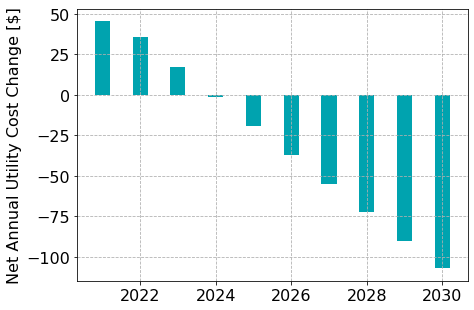

In [95]:
# Visualize
plt.figure(figsize=(7,5))
plt.bar(nat_gas_rate_df.Year,nat_gas_rate_df.Annual_Net_Cost_Change,color=step_blue, align = 'center', width = 0.4)
plt.grid(ls='--')
plt.ylabel('Net Annual Utility Cost Change [$]')